<h1 align="center">KNN on Wine Quality Dataset<h1>

## First let's import all the libraries we will be using in this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
from sklearn import neighbors

## Next we will define a function to load our data. Our data contains unwanted values till row 14. So, we will skip those values and also pass the list of column names to be used for ouor data-set.

In [2]:
def LoadDataSet(filename,column_names):
    column_names=["FixedAcidity","VolatileAcidity","CitricAcid","ResidualSugar","Chlorides","FreeSulfurDioxide","TotalSulfurDioxide","Density","pH","Sulphates","Alcohol","Quality"]
    load_data=pd.read_csv(filename,sep=",",engine="python",skiprows=14,names=column_names)
    return load_data

## Now we will define a function that will do all the pre-processing on the data:
## The pre-processing that we have done on our data can be divided into the following steps:
### 1. First we will explore and plot the data set.
### 2. Next we check the rows which have any null values. Print them and then drop them from the data set. We  will verify again that there are no more null values in the data set.
### 3.Next we will group our data set based on the "quality" feature. This shows the number of data points belonging to each quality class in our data set. 
### 3a. Next, We will observe that in our data set we have just one value each for the class "0" and class "11" of the quality column. This will create a problem while "stratifying" our data set to create train and test samples. So, we will drop these two rows from our data set.
### 4. Next we will check the number of zero filled values in each column and replace those entries with the standard deviation of the respective column to improve our accuracy and mis-classification.
### 5. Next, we will divide our data set to X and y features and scale our data points using the "Standard Scaler" and we will return the feature vector "X" and the target vector "y" to the calling function.

In [3]:
#Helper Function to check Number of Zeroes in each column
def checkIsZeroHelper(column_name,load_data):
    cnt=0
    for i in load_data.itertuples():
        r=i._asdict()
        if r[column_name] == 0:
            cnt+=1
    print("number of zeroes in ",column_name,"=",cnt)


def PreProcessData(load_data):
    print("Length of Original Data = ",len(load_data))
    print(load_data.head())
        
    plt.figure(figsize=(14,6))
    bins = np.arange(start=0, stop=200, step=1)
    plt.hist([load_data["FixedAcidity"],load_data["VolatileAcidity"],load_data["CitricAcid"],load_data["ResidualSugar"],load_data["Chlorides"],load_data["FreeSulfurDioxide"],load_data["TotalSulfurDioxide"],load_data["Density"],load_data["pH"],load_data["Sulphates"],load_data["Alcohol"],load_data["Quality"]], bins, label=load_data.columns)
    plt.legend(loc='upper right')
    plt.show()
    
    print("Printing columns with null values:\n\n")
    print(load_data.isnull().any())
    
    #Deleting the entire row with any null valued columnn
    null_columns=load_data.columns[load_data.isnull().any()]
    null_valued_rows=load_data[load_data.isnull().any(axis=1)][null_columns]
    for i in null_valued_rows.iterrows():
        load_data=load_data.drop([i[0]])
    
    print("Veifying if any column still has null value:\n\n")
    print(load_data.isnull().any())
    
    
    #Using GroupBy on Quality Feature to check the number of data points for each class type
    classes=(load_data.groupby(["Quality"]).count())
    print(classes)
    #We remove the rows corresponding to Quality classes 0 and 11.
    load_data = load_data[load_data.Quality != 0]
    load_data = load_data[load_data.Quality != 11]
    
    #Check the number of zeroes in each column and replace it with the standard deviation of the column
    columns=load_data.columns
    for i in columns:
        checkIsZeroHelper(i,load_data)
        
    #We replace the zeroes in Citric Acid Column since it is more
    load_data["CitricAcid"]=load_data["CitricAcid"].replace(0,np.nan)
    dev=load_data["CitricAcid"].std()
    load_data["CitricAcid"]=load_data["CitricAcid"].replace(np.nan,dev)
    
    #Next We will divide our data into fetaure and target vector
    X=load_data
    X=X.drop(["Quality"],axis=1)
    y=load_data["Quality"]
    
    #Next we will scale the feature vector using Standard Scaler
    scaler = StandardScaler()
    for feature in X.columns:
        X[feature] = scaler.fit_transform(X[feature].values.reshape(-1,1))
        
    return X,y
    


In [4]:
def KNearestClassifier_Unoptimized(X_train,X_test,y_train,y_test,k):
    neigh = KNeighborsClassifier(n_neighbors=k,weights='distance')
    neigh.fit(X_train, y_train)
    predicted_Classes=neigh.predict(X_test)
    print("\n\n\nAccuracy Score of Unoptimized K-Nearest Neighbor = ",neigh.score(X_test,y_test))

In [5]:
def CrossValidate(T,X,y,k):
    neigh = KNeighborsClassifier(n_neighbors=k,weights='distance')
    scores = cross_val_score(neigh,X,y,cv=T)
    print("\n\n\nCross Validation Results:")
    print("Accuracy Scores = ",scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [6]:
def GridSearch(T,R1,R2,X_train,X_test,y_train,y_test,X,y):
    leaf_size = list(range(1,50))
    n_neighbors=[]
    
    #We will consider only Odd Values of K. Since it will help in tie-breaking.
    for i in range(R1,R2):
        if i%2!=0:
            n_neighbors.append(i)
    p=[1,2]
    
    #In the weights parameter we will use the distance parameter. This will assign weights based on the distance for each point.
    hyperparameters = dict(leaf_size=leaf_size, n_neighbors=list(n_neighbors), p=p, weights=['distance'])
    
    neigh=KNeighborsClassifier()
    clf = GridSearchCV(neigh, hyperparameters, cv=5, n_jobs=-1)
    optimized_models=clf.fit(X_train, y_train)
    
    print("\n\n\nGridSearchCV Results:")
    print(sorted(clf.cv_results_.keys()))
    print(sorted(clf.cv_results_))
    
    print('Best leaf_size:', optimized_models.best_estimator_.get_params()['leaf_size'])
    print('Best p:', optimized_models.best_estimator_.get_params()['p'])
    print('Best n_neighbors:', optimized_models.best_estimator_.get_params()['n_neighbors'])
    print('Optimal model Score = ',optimized_models.score(X_test,y_test))
    
    opt_leaf_size=optimized_models.best_estimator_.get_params()['leaf_size']
    opt_p=optimized_models.best_estimator_.get_params()['p']
    opt_n=optimized_models.best_estimator_.get_params()['n_neighbors']
    
    
    #Next we will fit and plot the optimized model.
    X = X_test.values[:,:2]
    y = y_test
    
    clf = neighbors.KNeighborsClassifier(opt_n, weights='distance',p=opt_p,leaf_size=opt_leaf_size)
    clf.fit(X, y)
    
    #We will just consider first two columns for plotting the result
    #Note: Even PCA can be applied here.
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    cmap_colors = ListedColormap(['black','white','gray'])
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_colors)
    

Length of Original Data =  4901
   FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  Chlorides  \
0           7.0             0.27        0.36           20.7      0.045   
1           7.2             0.23        0.32            8.5      0.058   
2           7.2             0.23        0.32            8.5      0.058   
3           7.0             0.27        0.36           20.7      0.045   
4           6.3             0.30        0.34            1.6      0.049   

   FreeSulfurDioxide  TotalSulfurDioxide  Density    pH  Sulphates  Alcohol  \
0               45.0               170.0   1.0010  3.00       0.45      8.8   
1               47.0               186.0   0.9956  3.19       0.40      9.9   
2               47.0               186.0   0.9956  3.19       0.40      9.9   
3               45.0               170.0   1.0010  3.00       0.45      8.8   
4               14.0               132.0   0.9940  3.30       0.49      9.5   

   Quality  
0      6.0  
1      6.0  
2      6.

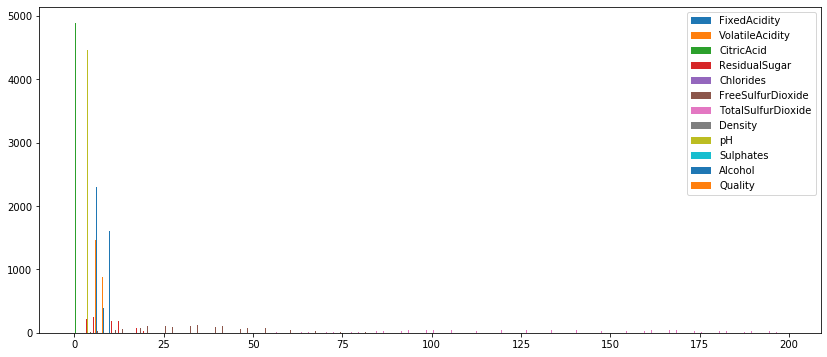

Printing columns with null values:


FixedAcidity          False
VolatileAcidity       False
CitricAcid            False
ResidualSugar         False
Chlorides             False
FreeSulfurDioxide     False
TotalSulfurDioxide    False
Density               False
pH                    False
Sulphates             False
Alcohol               False
Quality                True
dtype: bool
Veifying if any column still has null value:


FixedAcidity          False
VolatileAcidity       False
CitricAcid            False
ResidualSugar         False
Chlorides             False
FreeSulfurDioxide     False
TotalSulfurDioxide    False
Density               False
pH                    False
Sulphates             False
Alcohol               False
Quality               False
dtype: bool
         FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  Chlorides  \
Quality                                                                        
0.0                 1                1           1          

C:\Users\hithe\AppData\Local\Continuum\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)





GridSearchCV Results:
['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_leaf_size', 'param_n_neighbors', 'param_p', 'param_weights', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']
['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_leaf_size', 'param_n_neighbors', 'param_p', 'param_weights', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']
Best leaf_size: 1
Best p: 1
Best n_neighbors: 19
Optimal model Score =  0.6510204081632653


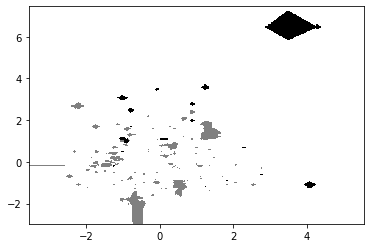

In [7]:
def main():
    load_data=LoadDataSet("./wine_quality.csv",["FixedAcidity","VolatileAcidity","CitricAcid","ResidualSugar","Chlorides","FreeSulfurDioxide","TotalSulfurDioxide","Density","pH","Sulphates","Alcohol","Quality"])
    X,y=PreProcessData(load_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42, stratify=y)
    
    k=int(input("Enter Initial K "))
    T=int(input("Enter Cross Validation term(T) "))
    R1=int(input("Enter start range of k for grid search "))
    R2=int(input("Enter end range of k for grid search "))
    
    #KNN Initial
    KNearestClassifier_Unoptimized(X_train,X_test,y_train,y_test,k)
    
    #Cross-Validate
    CrossValidate(T,X,y,k)
    
    #GridSearchCV
    GridSearch(T,R1,R2,X_train,X_test,y_train,y_test,X,y)
def __init__():
    main()
__init__()

## References:
### 1. Sklearn Documentation